In [1]:
# expand cells to the 95% of the display width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 95% !important; }</style>"))

# Tutorial: Automatic rule-based modeling of metabolism, protein-protein interactions, and regulation of gene expression employing *Atlas*

Authors: Rodrigo Santibáñez[1,2], Daniel Garrido[2], and Alberto Martín[1]

Date: August 2020

Affiliations:
1. Centro de Genómica y Bioinformática, Facultad de Ciencias, Universidad Mayor, Santiago, 8580745, Chile.
2. Department of Chemical and Bioprocess Engineering, School of Engineering, Pontificia Universidad Católica de Chile, Santiago, 7820436, Chile

Notes: This tutorial was created for the manuscript "*Atlas*: Automatic modeling of regulation of bacterial gene expression and metabolism using rule-based languages", first submitted for peer-review to Bioinformatics on May, 2020.

## Prerequisites

0. The tutorial was prepared and executed on Ubuntu 20.04, PathwayTools version 24, and docker engine version 19.03.8.<br/><br/>

1. PathwayTools must be installed and running to obtain data from the EcoCyc database. Please, run ```pathway-tools -lisp -python-local-only``` before to obtain any data.<br/>
   (Optional) The PathwayTools software could be executed in the background, with help of ```nohup pathway-tools -lisp -python-local-only > /dev/null 2> /dev/null &```.<br/>
   Please follow instructions at http://pathwaytools.org/ to obtain a licensed copy of the software from https://biocyc.org/download-bundle.shtml. However, data could be manually formatted using a text-based editor or a spreadsheet software.
   
   Note: If you ran into the ```pathway-tools/ptools/24.0/exe/aclssl.so: undefined symbol: CRYPTO_set_locking_callback``` error, please follow instructions here: https://github.com/glucksfall/atlas/tree/master/PTools-v24. Instructions will guide you to install a docker image that is able to run pathway tools, but does not include it, so you still need to obtain the software with a valid license.<br/><br/>
   
2. (Highly recommended) Install Docker. Please follow instructions for a supported Operating System https://docs.docker.com/engine/install/:<br/>
   On Ubuntu, install it with ```apt-get install docker.io```.<br/>
   On Win10, install Docker Desktop with WSL2 support https://docs.docker.com/docker-for-windows/wsl/.<br/>
   On MacOS, install Docker Desktop https://docs.docker.com/docker-for-mac/install/.<br/><br/>
   The Docker ```networkbiolab/pleiades```installs the python packages, the jupyter server, and the stochastic simulators.<br/><br/>

3. (Recommended) Jupyter notebook. We recommend the use of Anaconda3 https://www.anaconda.com/products/individual because of the easier installation of the stochastic simulators from https://anaconda.org/alubbock.<br/><br/>

4. (Optional) A stochastic simulator, supported by the pySB python package ([BNG2](https://github.com/RuleWorld/bionetgen), [NFsim](https://github.com/ruleworld/nfsim/tree/9178d44455f6e27a81f398074eeaafb2a1a4b4bd), [KaSim](https://github.com/Kappa-Dev/KappaTools) or [Stochkit](https://github.com/StochSS/StochKit)). pySB requires BNG2 to simulate models with NFsim.<br/><br/>

5. (Optional) Cytoscape to visualize metabolic networks and others.<br/><br/>

6. (Optional) A deterministic simulator: pySB supports ODE integration via scipy.integrate.ode, BioNetGen ODE integration, and CUDA-accelerated ODE integration with Marco S. Nobile's cupSODA software (https://github.com/aresio/cupSODA). If the user feel comfortable with SBML models, pySB could export to SBML and deterministic simulation done with libRoadRunner (http://libroadrunner.org/), Tellurium (http://tellurium.analogmachine.org/), COPASI (http://copasi.org/), etc.

## Installation

0. If you are running the docker image "pleiades", please go directly to the section "Preamble".<br/><br/>
1. To install, please follow one of the following steps:<br/><br/>
   1. Install the docker image "pleiades" using ```docker pull networkbiolab/pleiades```. The container is based on the Anaconda3 software and it installs Atlas, and the stochastic simulators BNG2, NFsim, KaSim, and Stochkit. After building the image, please run the container with ```docker run --detach --publish 10000:8888 networkbiolab/pleiades```, and go to ```localhost:10000``` in your preferred browser. The required password is ```pleiades```.<br/><br/>
   2. Download or clone the Github repository from https://github.com/networkbiolab/pleiades with ```git clone https://github.com/networkbiolab/pleiades foo``` (where ```foo``` is an absolute or relative path). Then, you could build the docker image with ```docker build foo --tag pleiades``` and run it with ```docker run --detach --publish 10000:8888 pleiades```. Finally, go to ```localhost:10000``` in your preferred browser. The required password is ```pleiades```.<br/><br/>
   3. Install with pip3: ```sudo -H python3 -m pip install pleiades``` or ```python3 -m pip install pleiades --user```. Pleiades is a meta-package that install Atlas (the rule-based modeller), Pleione (a genetic algorithm for parameter calibration of RBMs, compatible with SLURM), Alcyone (to perform identifiability analysis of parameters), and Sterope (to perform sensitivity analysis of parameters in kappa RBMs, compatible with SLURM).<br/>
      You should install, configure, and run the jupyter notebook on your own: example ```sudo -H pip3 install jupyter && nohup python3 -m jupyter notebook --port=8888 --no-browser --port-retries=0 > /dev/null 2> /dev/null &```.<br/><br/>
   4. Download or clone the Github repository from https://github.com/networkbiolab/atlas with ```git clone https://github.com/networkbiolab/atlas foo``` (where ```foo``` is an absolute or relative path). Requisites must be fulfilled manually with pip3: ```sudo -H python3 -m pip install pandas pysb pythoncyc jupyter seaborn``` or ```python3 -m pip install pandas pysb pythoncyc jupyter seaborn --user```.

## Objectives

1. Get metabolic data: enzyme names, substrates, products, and location of enzymes.
2. Basic manipulations of metabolic data: change reversibility, change enzyme location.
3. Get composition of complexes for protein-protein interactions.
4. Basic manipulations of interaction data: add and remove interactions.
5. Perform simulation, plot of variables, and export of models.
6. Get DNA architecture and build a model from a manually written network.
7. Get protein-DNA and TF-metabolite interactions and build a model from manually written networks.
8. Add gene regulatory interactions to transcription rules: Activation of transcription.

## Preamble: load *Atlas*

In [2]:
# testing source code
# required if atlas was cloned from GitHub and this notebook is executed from the tutorial directory.
import sys
sys.path.append("..")

import atlas_rbm.atlas as atlas
import atlas_rbm.utils as utils
import atlas_rbm.export as export
import atlas_rbm.simulation as simulation

In [3]:
utils.checkPathwayTools()

PathwayTools is running. Available PGDB are: META, ECOLI


True

In [4]:
utils.execPToolsDocker('ptools-v24')

Doing nothing since PathwayTools is running.


## Getting data to model metabolism

In this tutorial, we will obtain data from EcoCyc to model the lactose degradation that ocurr in *Escherichia coli*. We choose the lactose metabolism since it was discovered in the decade of 1960s and it is a common model of gene regulation with more than 50 years of biochemical information. In an side note, the characterization of the lactose operon and others rewarded their authors the 1965 Nobel Prize in Physiology or Medicine (https://www.nobelprize.org/prizes/medicine/1965/summary/)

The lactose operon from *E. coli* consists of three genes: the $\beta$-galactosidase gene lacZ, the lactose permease gene lacY (also known as lactose-proton symporter), and the galactoside O-acetyltransferase gene lacA.

**Note**: The location is informed for all gene products, including the location of complexes formed by the encoded protein. Therefore, the location may reflect the location of the enzyme or its components before complex assembly. Still, there are 154 enzymatic and 3 transport reactions without known gene, and the location will set to unknown. 

**Note**: The location could be changed later with help of an utilitary function. The function ```utils.metabolicNetwork.FromEnzymeList()``` produces data in three formats for the ```GENE OR COMPLEX``` column:
1. The ```product``` key produces networks with the name of the enzyme, but the model will not be compatible with the modeling of gene expression.<br/>
   **Note**: The ```product``` key will try to retrieve the location of the enzyme or transporter. If not, the location refer to the location of the monomers of the complex, e.g. "BETAGALACTOSID-CPLX".<br/><br/>
2. The ```gene``` key produces networks with the name of the gene (is the default), but the model will not be compatible with modeling of protein-protein interactions, specially for the modeling of heteromers.<br/>
   **Note**: For enzyme complexes, the ```genes``` key will decompose the complex into its genes and locations of their products, e.g. the araFGH transporter ("ABC-2-CPLX") where the araG product locates to the cytoplasm and the inner membrane when interact with araH.<br/><br/>
3. The ```complex``` key produces hyper-networks (brackets denote subnetworks, and we will subsequently call it as *hypergraph notation*), and in that way, Atlas produces a model that will be compatible with the modeling of protein-protein interactions and gene expression.<br/>
   **Note**: For enzyme complexes, the ```complex``` key will decompose the complex into its genes AND write the stoichiometry of the complex in the *hypergraph notation*. If one or more monomers have two or more locations, the output will show as many rows to show all combinations. Be aware that some could be not physiologically possible.

In [5]:
%time network = utils.metabolicNetwork.FromEnzymeList('ECOLI', ['GALACTOACETYLTRAN-CPLX', 'LACY-MONOMER', 'BETAGALACTOSID-CPLX', 'ABC-2-CPLX'], fmt = 'product')
network

CPU times: user 73.5 ms, sys: 32.6 ms, total: 106 ms
Wall time: 972 ms


,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,ABC-2-CPLX,inner membrane,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
1,BETAGALACTOSID-CPLX,cytosol,BETAGALACTOSID-RXN,"CPD-15972,WATER","GALACTOSE,Glucopyranose",1.0,0.0
2,BETAGALACTOSID-CPLX,cytosol,RXN0-5363,Alpha-lactose,ALLOLACTOSE,1.0,1.0
3,BETAGALACTOSID-CPLX,cytosol,RXN-17726,"CPD-3561,WATER","GALACTOSE,Fructofuranose",1.0,0.0
4,BETAGALACTOSID-CPLX,cytosol,RXN0-7219,"CPD-3785,WATER","GALACTOSE,D-ARABINOSE",1.0,0.0
5,GALACTOACETYLTRAN-CPLX,cytosol,GALACTOACETYLTRAN-RXN,"Beta-D-Galactosides,ACETYL-COA","6-Acetyl-Beta-D-Galactosides,CO-A",1.0,0.0
6,LACY-MONOMER,inner membrane,TRANS-RXN-24,"PROTON,Alpha-lactose","PROTON,Alpha-lactose",1.0,1.0
7,LACY-MONOMER,inner membrane,TRANS-RXN-94,"PROTON,MELIBIOSE","PROTON,MELIBIOSE",1.0,1.0
8,LACY-MONOMER,inner membrane,RXN0-7215,"PROTON,CPD-3561","PROTON,CPD-3561",1.0,1.0
9,LACY-MONOMER,inner membrane,RXN0-7217,"PROTON,CPD-3785","PROTON,CPD-3785",1.0,1.0


**Note**: Using the ```utils.metabolicNetwork.FromEnzymeList()``` function with the ```all_enzymes()``` and ```all_transporters()``` functions from the pythoncyc package, we could obtain a **draft** network and a **draf** rule-based model of metabolism for the considered organism:

In [6]:
# import pythoncyc
%time network = utils.metabolicNetwork.FromEnzymeList('ECOLI', pythoncyc.select_organism('ECOLI').all_transporters())
%time utils.metabolicNetwork.expand_network(network, 'ecocyc-v24-tps-cytoscape.txt')
network.to_csv('ecoli-tps-v24.txt', sep = '\t', index = False)
%time atlas.construct_model_from_metabolic_network('ecoli-tps-v24.txt', noObservables=True, noInitials=True, toFile = 'model-transporters.py')
len(network[network['ENZYME LOCATION'].str.match('unknown')]) # how many reactions are not mapped to a gene product

NameError: name 'pythoncyc' is not defined

CPU times: user 1.61 ms, sys: 516 µs, total: 2.13 ms
Wall time: 1.76 ms
CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 15.6 ms


0

In [7]:
import pythoncyc
%time network = utils.metabolicNetwork.FromEnzymeList('ECOLI', pythoncyc.select_organism('ECOLI').all_enzymes())
%time utils.metabolicNetwork.expand_network(network, 'ecocyc-v24-enz-cytoscape.txt')
network.to_csv('ecoli-enz-v24.txt', sep = '\t', index = False)
%time atlas.construct_model_from_metabolic_network('ecoli-enz-v24.txt', noObservables=True, noInitials=True, toFile = 'model-enzymes.py')
len(network[network['ENZYME LOCATION'].str.match('unknown')]) # how many reactions are not mapped to a gene product

Unable to retrieve data for CPLX0-7889. Please, review the information at https://biocyc.org/ECOLI/NEW-IMAGE?object=CPLX0-7889 and post an issue at https://github.com/networkbiolab/atlas if you believe it is a software error.
CPU times: user 10.5 s, sys: 9.28 s, total: 19.7 s
Wall time: 2min 51s
CPU times: user 33.5 ms, sys: 834 µs, total: 34.3 ms
Wall time: 34 ms
It was found duplicated reaction names in the network.
Please check the conflicting_reactions.txt and correct them if necessary.
CPU times: user 1.28 s, sys: 62.3 ms, total: 1.34 s
Wall time: 1.34 s


155

However, we must know the exact enzyme ID from the database. As an alternative, we could obtain the metabolic reactions from the ```ECOLI``` database from PathwayTools with help of the ```utils.metabolicNetwork.FromGeneList()``` function. The function produce data in three formats for the ```GENE OR COMPLEX``` column:
1. The ```product``` key produces networks with the name of the enzyme, but the model will not be compatible with the modeling of gene expression.<br/>
   **Note**: The ```product``` key will find the product that perform the enzymatic reaction, e.g. lacZ produces monomers that interact to produce the enzyme. Also, it will write the location of the product(s) of the queried gene. It is a good practice to query only one gene of the complex.<br/><br/>
2. The ```gene``` key produces networks with the name of the gene (is the default), but the model will not be compatible with modeling of protein-protein interactions, specially for the modeling of heteromers.<br/>
   **Note**: The ```gene``` key will write the location of the product(s) of the queried gene., e.g. araF, araG, and araH.<br/><br/>
3. The ```complex``` key produces hyper-networks, and in that way, Atlas will produce a model that is compatible with the modeling of protein-protein interactions and gene expression.<br/>
   **Note**: The ```complex``` key will write the stoichiometry of the enzymatic complex of the queried gene, and the mapped location of the complex, all in *hypergraph notation*. It is a good practice query only one gene of the complex.

In [8]:
%time utils.metabolicNetwork.FromGeneList('ECOLI', ['lacZ', 'lacA', 'lacY', 'araF', 'araG', 'araH'], fmt = 'product')

CPU times: user 2.58 s, sys: 2.44 s, total: 5.02 s
Wall time: 49.8 s


,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,ABC-2-CPLX,periplasmic space,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
1,ABC-2-CPLX,inner membrane,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
2,ABC-2-CPLX,cytosol,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
3,ABC-2-CPLX,inner membrane,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
4,GALACTOACETYLTRAN-CPLX,cytosol,GALACTOACETYLTRAN-RXN,"Beta-D-Galactosides,ACETYL-COA","6-Acetyl-Beta-D-Galactosides,CO-A",1.0,0.0
5,LACY-MONOMER,inner membrane,TRANS-RXN-24,"PROTON,Alpha-lactose","PROTON,Alpha-lactose",1.0,1.0
6,LACY-MONOMER,inner membrane,TRANS-RXN-94,"PROTON,MELIBIOSE","PROTON,MELIBIOSE",1.0,1.0
7,LACY-MONOMER,inner membrane,RXN0-7215,"PROTON,CPD-3561","PROTON,CPD-3561",1.0,1.0
8,LACY-MONOMER,inner membrane,RXN0-7217,"PROTON,CPD-3785","PROTON,CPD-3785",1.0,1.0
9,LACY-MONOMER,inner membrane,RXN-17755,"PROTON,CPD-3801","PROTON,CPD-3801",1.0,1.0


**Note**: The function is particularly slow since it needs to build a dataframe to map gene names (e.g. *lacY*) to the internal identification name that PathwayTools understand: ```EG10526``` <-> ```lacY```. With that internal identification, the function looks for enzymes, reactions of those enzymes, the substrates and products of those reactions, and the location of the enzymes. We could accelerate the process (useful for repeated gathering of data) if we execute ```utils.returnCommonNames()``` and utilize that precalculated dataframe and pass to the utilitary functions.

In [9]:
# %time utils.getData('ECOLI', 'EG10526')
%time utils.getData('ECOLI', 'EG10526')['common_name'] # for simplicity of the output

CPU times: user 1.06 ms, sys: 752 µs, total: 1.81 ms
Wall time: 13.1 ms


'lacY'

In [10]:
%time df_genes = utils.returnCommonNames('ECOLI')

CPU times: user 2.88 s, sys: 2.21 s, total: 5.09 s
Wall time: 48.8 s


In [11]:
%time utils.metabolicNetwork.FromGeneList('ECOLI', ['lacZ', 'lacA', 'lacY', 'araF', 'araG', 'araH'], fmt = 'product', precalculated = df_genes)
# ~35 times faster

CPU times: user 111 ms, sys: 28.2 ms, total: 139 ms
Wall time: 1.32 s


,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,ABC-2-CPLX,periplasmic space,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
1,ABC-2-CPLX,inner membrane,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
2,ABC-2-CPLX,cytosol,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
3,ABC-2-CPLX,inner membrane,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
4,GALACTOACETYLTRAN-CPLX,cytosol,GALACTOACETYLTRAN-RXN,"Beta-D-Galactosides,ACETYL-COA","6-Acetyl-Beta-D-Galactosides,CO-A",1.0,0.0
5,LACY-MONOMER,inner membrane,TRANS-RXN-24,"PROTON,Alpha-lactose","PROTON,Alpha-lactose",1.0,1.0
6,LACY-MONOMER,inner membrane,TRANS-RXN-94,"PROTON,MELIBIOSE","PROTON,MELIBIOSE",1.0,1.0
7,LACY-MONOMER,inner membrane,RXN0-7215,"PROTON,CPD-3561","PROTON,CPD-3561",1.0,1.0
8,LACY-MONOMER,inner membrane,RXN0-7217,"PROTON,CPD-3785","PROTON,CPD-3785",1.0,1.0
9,LACY-MONOMER,inner membrane,RXN-17755,"PROTON,CPD-3801","PROTON,CPD-3801",1.0,1.0


In [12]:
%time utils.metabolicNetwork.FromGeneList('ECOLI', ['lacZ', 'lacA', 'lacY', 'araF', 'araG', 'araH'], fmt = 'genes', precalculated = df_genes)

CPU times: user 72.1 ms, sys: 64.2 ms, total: 136 ms
Wall time: 1.39 s


,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,araF,periplasmic space,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
1,araG,inner membrane,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
2,araG,cytosol,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
3,araH,inner membrane,ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
4,lacA,cytosol,GALACTOACETYLTRAN-RXN,"Beta-D-Galactosides,ACETYL-COA","6-Acetyl-Beta-D-Galactosides,CO-A",1.0,0.0
5,lacY,inner membrane,TRANS-RXN-24,"PROTON,Alpha-lactose","PROTON,Alpha-lactose",1.0,1.0
6,lacY,inner membrane,TRANS-RXN-94,"PROTON,MELIBIOSE","PROTON,MELIBIOSE",1.0,1.0
7,lacY,inner membrane,RXN0-7215,"PROTON,CPD-3561","PROTON,CPD-3561",1.0,1.0
8,lacY,inner membrane,RXN0-7217,"PROTON,CPD-3785","PROTON,CPD-3785",1.0,1.0
9,lacY,inner membrane,RXN-17755,"PROTON,CPD-3801","PROTON,CPD-3801",1.0,1.0


In [13]:
%time utils.metabolicNetwork.FromGeneList('ECOLI', ['lacZ', 'lacA', 'lacY', 'araF', 'araG', 'araH'], fmt = 'complex', precalculated = df_genes)

CPU times: user 142 ms, sys: 116 ms, total: 258 ms
Wall time: 2.25 s


,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,"[araG,araG,araH,araH,araF]","[inner membrane,inner membrane,inner membrane,...",ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
1,"[araG,araG,araH,araH,araF]","[cytosol,cytosol,inner membrane,inner membrane...",ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
2,"[araG,araG,araH,araH,araF]","[inner membrane,inner membrane,inner membrane,...",ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
3,"[araG,araG,araH,araH,araF]","[cytosol,cytosol,inner membrane,inner membrane...",ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
4,"[araG,araG,araH,araH,araF]","[inner membrane,inner membrane,inner membrane,...",ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
5,"[araG,araG,araH,araH,araF]","[cytosol,cytosol,inner membrane,inner membrane...",ABC-2-RXN,"WATER,ATP,L-ARABINOSE","Pi,ADP,PROTON,L-ARABINOSE",1.0,0.0
6,"[lacA,lacA,lacA]","[cytosol,cytosol,cytosol]",GALACTOACETYLTRAN-RXN,"Beta-D-Galactosides,ACETYL-COA","6-Acetyl-Beta-D-Galactosides,CO-A",1.0,0.0
7,lacY,inner membrane,TRANS-RXN-24,"PROTON,Alpha-lactose","PROTON,Alpha-lactose",1.0,1.0
8,lacY,inner membrane,TRANS-RXN-94,"PROTON,MELIBIOSE","PROTON,MELIBIOSE",1.0,1.0
9,lacY,inner membrane,RXN0-7215,"PROTON,CPD-3561","PROTON,CPD-3561",1.0,1.0


The output is a pandas dataframe that could be exported with ```network.to_csv(path)```, or in a two-columns format that Cytoscape could interpret as a network. The ```utils.metabolicNetwork.expand_network``` function reorders and exports the dataframe as a text file (in this case to ```./tutorial.txt```).

In [14]:
%time network = utils.metabolicNetwork.FromGeneList('ECOLI', ['lacZ', 'lacA', 'lacY'], fmt = 'genes', precalculated = df_genes)
%time utils.metabolicNetwork.expand_network(network, './lactose-metabolism-cytoscape-v1.txt')

CPU times: user 60.1 ms, sys: 42.9 ms, total: 103 ms
Wall time: 986 ms
CPU times: user 2.29 ms, sys: 0 ns, total: 2.29 ms
Wall time: 2.06 ms


The following image was prepared from the ```tutorial.txt``` file, and you could reproduce it with Cytoscape:<br/>
1. Click on the ```Import Network from File System``` icon or click on ```File -> Import -> Network from File...```.
2. Navigate to the file and click on ```Open```.
3. SOURCE, TARGET, and EDGE ATTRIBUTE are OK, but the 4th columns must be the SOURCE NODE ATTRIBUTE and the 5th column the TARGET NODE ATTRIBUTE. Click on the header and change it to the correct attribute. The attributes will help later to filter and to add format to nodes and edges.
4. Click on ```Filter``` (on the right), then on the ```+``` icon and finally on ```Column Filter```:
  1. On the selector, click on ```Edge: EDGE_ATTRIBUTE``` and change ```contains``` to ```is```.
    1. Write ```NO_REVERSIBLE``` that will select edges that correspond to irreversible reactions. Click on ```Style```, then ```Edge``` (in the bottom), and click on the 3rd column to bypass the format of the ```Target Arrow Shape``` and select your favorite arrow shape.
    2. Write ```REVERSIBLE``` and bypass the format of the ```Source Arrow Shape``` AND ```Target Arrow Shape```, and select your favorite arrow shape.
  2. On the selector, click on ```Node: SOURCE_NODE_ATTRIBUTE```:
    1. Write ```RXN``` that will select nodes enconding the reactions. Click on ```Style```, then on ```Node``` and bypass the ```Fill Color```. In the new window, you could set-up the color, e.g. #00AA50
    2. Write ```GENE_PROD``` that will select nodes encoding the gene name, protein name, or the enzyme name. Click on ```Style```, then on ```Node``` and bypass the ```Fill Color```. In the new window, you could set-up the color, e.g. #CC0033
    3. Write ```MET``` that will select nodes encoding substrate metabolites. Click on ```Style```, then on ```Node``` and bypass the ```Fill Color```. In the new window, you could set-up the color, e.g. #00ABDD. Also, set a shape for nodes, to differentiate substrates from products.
  3. On the selector, click on ```Node: TARGET_NODE_ATTRIBUTE```:
    1. Write ```MET``` that will select nodes encoding product metabolites. Click on ```Style```, then on ```Node``` and bypass the ```Fill Color```. In the new window, you could set-up the color, e.g. #00ABDD
    
<a id='figS1'></a>The result will be similar to <img src="lactose-metabolism-cytoscape-v1.png" alt="drawing" width="1000"/>

If we inspect the network, we could highlight four things:
1. The lacA reaction is disconnect from the network formed by the lacZ and lacY reactions;
2. The lacY reactions do not inform the metabolite compartment, so substrates and products refer to the same node;
3. The utilization of *internal codes* for certain compounds; and
4. The impossibility of alpha-lactose degradation into glucose (glucopyranose) and galactose.

We could retrieve information from the reaction and metabolite nodes with the ```utils.getData()```function:

In [15]:
# utils.get_data('ECOLI', 'CPD-3561')
%time utils.getData('ECOLI', 'CPD-3561')['names'] # for simplicity of the output

CPU times: user 0 ns, sys: 2.33 ms, total: 2.33 ms
Wall time: 17.3 ms


['lactulose', 'CEPHULAC (TN)']

We observe that ```CPD-3561``` correspond to [```lactulose```](https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:6359). Therefore, the EcoCyc database informs that LacY is able to incorporate [alpha-lactose](https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:36219), [melibiose](https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:28053), lactulose (```CPD-3561```), 3-O-galactosylarabinose ([```CPD-3785```](https://www.ebi.ac.uk/chebi/searchId.do?chebiId=CHEBI:73916)), and melibionate ([```CPD-3801```](https://pubchem.ncbi.nlm.nih.gov/compound/Melibionate)) into the cell cytoplasm. Interestingly, the common synthetic activator IPTG (o-nitrophenyl-𝛽-galactoside) is mentioned in the description for the lactose transporter (https://biocyc.org/gene?orgid=ECOLI&id=EG10526#), but there is no inclusion of the IPTG transport in the reactions of LacY.

In [16]:
# utils.get_data('ECOLI', 'CPD-15972')
%time utils.getData('ECOLI', 'CPD-15972')['names'] # for simplicity of the output

CPU times: user 990 µs, sys: 706 µs, total: 1.7 ms
Wall time: 15.5 ms


['lactose',
 '&beta;-D-galactopyranosyl-(1&rarr;4)-D-glucopyranose',
 'D-lactose',
 '&beta;-D-Galp-(1&rarr;4)-D-Glcp']

Next, EcoCyc informs that LacZ could metabolize lactose  (```CPD-15972```) into galactose and glucopyranose, lactulose into 𝛽-galactose and fructofuranose, and 3-O-galactosylarabinose into 𝛽-galactose and arabinose. The difference in metabolite names between the lacY and lacZ reactions is enough to make a [disconnected pathway](#figS1). Specifically, the name lactose refers to the two anomers $\alpha$- and $\beta$-lactose because of EcoCyc uses generic names when enzymes show no stereoselectivity. In addition, galactose has also an anomeric center, but the database refers to it as $\beta$-D-galactose without indication the enzyme could produce $\alpha$-galactose from $\alpha$-lactose. 

<!---
Interestingly, galactose is able of mutarotation in solution (transition from the $\alpha$- to the $\beta$-anomer, and vice versa) and the galM gene product is required to convert $\beta$-galactose in $\alpha$-galactose for subsequent metabolic reactions only when the cell grows in lactose, but not when the cell grows in galactose. Moreover, a report shows that LacZ is able to hydrolyze $\alpha$-lactose into $\alpha$-galactose and $\alpha$-glucose \citep{Huber1981anomeric}. Another discordance refers to the description of the lactose pathway at EcoCyc, where the database describes that the $\beta$-galactosidase enzyme is able to hydrolyze allolactose into galactose and glucose \citep{Juers2012LacZ}, but the same information is missing from the description of the lacZ reactions (as similar was the case for IPTG transport by the lacY gene product). In addition, there is a report showing that the lactose permease could transport $\beta$-lactose as well as $\alpha$-lactose through the cell membrane \citep{Huber1981anomeric}, and the apparent physiological non-importance of lacA gene product contrast with the plausibility to convert $\beta$-galactose (a $\beta$-D-galactoside) into 6-acetyl-$\beta$-galactose.
--->

In [17]:
%time print(utils.getData('ECOLI', 'GALACTOSE')['common_name'])
print()
%time print(utils.getData('ECOLI', 'GALACTOSE')['synonyms'])

&beta;-D-galactopyranose
CPU times: user 1.32 ms, sys: 943 µs, total: 2.27 ms
Wall time: 27 ms

['&beta;-D-galactopyranose', '&beta;-D-galactose', 'cerebrose', '6-(hydroxymethyl)tetrahydropyran-2,3,4,5-tetraol']
CPU times: user 0 ns, sys: 2.46 ms, total: 2.46 ms
Wall time: 22.1 ms


The advantage of the procedure is the ability to modify the data programatically using python functions (https://pandas.pydata.org/) or export the data and manipulate it using a text processor or a spreadsheet software. For routinary changes, we included utilitary functions to make batch manipulation to the data:

In [18]:
# Transport reactions: Add compartments to substrates and/or products
%time network = utils.metabolicNetwork.setTransport(network, geneLst = ['lacY'], fromLst = ['PER'], toLst = ['CYT'])
network

CPU times: user 5.83 ms, sys: 3.84 ms, total: 9.67 ms
Wall time: 9.29 ms


,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,lacA,cytosol,GALACTOACETYLTRAN-RXN,"Beta-D-Galactosides,ACETYL-COA","6-Acetyl-Beta-D-Galactosides,CO-A",1.0,0.0
1,lacY,inner membrane,TRANS-RXN-24,"PER-PROTON,PER-Alpha-lactose","PROTON,Alpha-lactose",1.0,1.0
2,lacY,inner membrane,TRANS-RXN-94,"PER-PROTON,PER-MELIBIOSE","PROTON,MELIBIOSE",1.0,1.0
3,lacY,inner membrane,RXN0-7215,"PER-PROTON,PER-CPD-3561","PROTON,CPD-3561",1.0,1.0
4,lacY,inner membrane,RXN0-7217,"PER-PROTON,PER-CPD-3785","PROTON,CPD-3785",1.0,1.0
5,lacY,inner membrane,RXN-17755,"PER-PROTON,PER-CPD-3801","PROTON,CPD-3801",1.0,1.0
6,lacZ,cytosol,BETAGALACTOSID-RXN,"CPD-15972,WATER","GALACTOSE,Glucopyranose",1.0,0.0
7,lacZ,cytosol,RXN0-5363,Alpha-lactose,ALLOLACTOSE,1.0,1.0
8,lacZ,cytosol,RXN-17726,"CPD-3561,WATER","GALACTOSE,Fructofuranose",1.0,0.0
9,lacZ,cytosol,RXN0-7219,"CPD-3785,WATER","GALACTOSE,D-ARABINOSE",1.0,0.0


**Note**: By default, Atlas interprets the default location of monomers as cytoplasmatic. When setting the location to ```CYT```, the ```setTransport()``` function will delete a previous compartment or append nothing to the name of the monomer.

In [19]:
# Irreversibility of reactions per gene: Change the Reverse Rate to zero
%time network = utils.metabolicNetwork.setIrreversibility(network, geneLst = ['lacY', 'lacA'])
network

CPU times: user 3.12 ms, sys: 0 ns, total: 3.12 ms
Wall time: 2.99 ms


,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,lacA,cytosol,GALACTOACETYLTRAN-RXN,"Beta-D-Galactosides,ACETYL-COA","6-Acetyl-Beta-D-Galactosides,CO-A",1.0,0.0
1,lacY,inner membrane,TRANS-RXN-24,"PER-PROTON,PER-Alpha-lactose","PROTON,Alpha-lactose",1.0,0.0
2,lacY,inner membrane,TRANS-RXN-94,"PER-PROTON,PER-MELIBIOSE","PROTON,MELIBIOSE",1.0,0.0
3,lacY,inner membrane,RXN0-7215,"PER-PROTON,PER-CPD-3561","PROTON,CPD-3561",1.0,0.0
4,lacY,inner membrane,RXN0-7217,"PER-PROTON,PER-CPD-3785","PROTON,CPD-3785",1.0,0.0
5,lacY,inner membrane,RXN-17755,"PER-PROTON,PER-CPD-3801","PROTON,CPD-3801",1.0,0.0
6,lacZ,cytosol,BETAGALACTOSID-RXN,"CPD-15972,WATER","GALACTOSE,Glucopyranose",1.0,0.0
7,lacZ,cytosol,RXN0-5363,Alpha-lactose,ALLOLACTOSE,1.0,1.0
8,lacZ,cytosol,RXN-17726,"CPD-3561,WATER","GALACTOSE,Fructofuranose",1.0,0.0
9,lacZ,cytosol,RXN0-7219,"CPD-3785,WATER","GALACTOSE,D-ARABINOSE",1.0,0.0


In [20]:
# Irreversibility of reactions per reaction. The beta-galactosidase has also isomerase activity (reversible reaction)
%time network = utils.metabolicNetwork.setIrreversibility(network, rxnLst = ['BETAGALACTOSID-RXN', 'RXN-17726', 'RXN0-7219'])
network

CPU times: user 3.65 ms, sys: 0 ns, total: 3.65 ms
Wall time: 3.46 ms


,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,lacA,cytosol,GALACTOACETYLTRAN-RXN,"Beta-D-Galactosides,ACETYL-COA","6-Acetyl-Beta-D-Galactosides,CO-A",1.0,0.0
1,lacY,inner membrane,TRANS-RXN-24,"PER-PROTON,PER-Alpha-lactose","PROTON,Alpha-lactose",1.0,0.0
2,lacY,inner membrane,TRANS-RXN-94,"PER-PROTON,PER-MELIBIOSE","PROTON,MELIBIOSE",1.0,0.0
3,lacY,inner membrane,RXN0-7215,"PER-PROTON,PER-CPD-3561","PROTON,CPD-3561",1.0,0.0
4,lacY,inner membrane,RXN0-7217,"PER-PROTON,PER-CPD-3785","PROTON,CPD-3785",1.0,0.0
5,lacY,inner membrane,RXN-17755,"PER-PROTON,PER-CPD-3801","PROTON,CPD-3801",1.0,0.0
6,lacZ,cytosol,BETAGALACTOSID-RXN,"CPD-15972,WATER","GALACTOSE,Glucopyranose",1.0,0.0
7,lacZ,cytosol,RXN0-5363,Alpha-lactose,ALLOLACTOSE,1.0,1.0
8,lacZ,cytosol,RXN-17726,"CPD-3561,WATER","GALACTOSE,Fructofuranose",1.0,0.0
9,lacZ,cytosol,RXN0-7219,"CPD-3785,WATER","GALACTOSE,D-ARABINOSE",1.0,0.0


In [21]:
# Compartment of reactions. The lacY gene is a protein located to the inner membrane of E.coli
%time network = utils.metabolicNetwork.setEnzymeLocation(network, geneLst = ['lacY'], compartmentLst = ['iMEM'])
network

CPU times: user 1.28 ms, sys: 0 ns, total: 1.28 ms
Wall time: 1.25 ms


,GENE OR COMPLEX,ENZYME LOCATION,REACTION,SUBSTRATES,PRODUCTS,FWD_RATE,RVS_RATE
0,lacA,cytosol,GALACTOACETYLTRAN-RXN,"Beta-D-Galactosides,ACETYL-COA","6-Acetyl-Beta-D-Galactosides,CO-A",1.0,0.0
1,lacY,inner membrane,TRANS-RXN-24,"PER-PROTON,PER-Alpha-lactose","PROTON,Alpha-lactose",1.0,0.0
2,lacY,inner membrane,TRANS-RXN-94,"PER-PROTON,PER-MELIBIOSE","PROTON,MELIBIOSE",1.0,0.0
3,lacY,inner membrane,RXN0-7215,"PER-PROTON,PER-CPD-3561","PROTON,CPD-3561",1.0,0.0
4,lacY,inner membrane,RXN0-7217,"PER-PROTON,PER-CPD-3785","PROTON,CPD-3785",1.0,0.0
5,lacY,inner membrane,RXN-17755,"PER-PROTON,PER-CPD-3801","PROTON,CPD-3801",1.0,0.0
6,lacZ,cytosol,BETAGALACTOSID-RXN,"CPD-15972,WATER","GALACTOSE,Glucopyranose",1.0,0.0
7,lacZ,cytosol,RXN0-5363,Alpha-lactose,ALLOLACTOSE,1.0,1.0
8,lacZ,cytosol,RXN-17726,"CPD-3561,WATER","GALACTOSE,Fructofuranose",1.0,0.0
9,lacZ,cytosol,RXN0-7219,"CPD-3785,WATER","GALACTOSE,D-ARABINOSE",1.0,0.0


In [22]:
%time utils.metabolicNetwork.expand_network(network, './lactose-metabolism-cytoscape-v2.txt')

CPU times: user 1.37 ms, sys: 976 µs, total: 2.35 ms
Wall time: 1.85 ms


<a id='figS2'></a><img src="lactose-metabolism-cytoscape-v2.png" alt="drawing" width="1000"/>

In [23]:
%time model = atlas.construct_model_from_metabolic_network(network, verbose = False, toFile = 'test.py') # verbose = True will print the pySB functions needed to reproduce the model
model

CPU times: user 16.6 ms, sys: 0 ns, total: 16.6 ms
Wall time: 15.9 ms


In [24]:
utils.analyseConnectivity(model, '/opt/git-repositories/KaSim.Kappa-Dev/KaSa')

Exception: Type of model not supported yet.

**Note**: Even with an initial condition of zero, KaSA will report reactions as reacheables because it analyzes the connectivity of the network. Unreacheable rules or agents will those that: first, monomers are not instantiated (missing ```%init:``` statements in ```kappa```), and two, *Rules* not producing the monomers in the required state (e.g. phosphorylation). For sake of completeness, we produced kappa files that fail the connectivity analysis:

In [25]:
utils.analyseConnectivity('fail_rules.kappa', path = '/opt/git-repositories/KaSim.Kappa-Dev/KaSa')
# Missing instantiation of the lacA trimer, so impossibility to catalyze its reactions

There are some non applicable rules: 
rule GALACTOACETYLTRAN_RXN_galactose (File "fail_rules.kappa", line 187, characters 34-534:) will never be applied.
rule GALACTOACETYLTRAN_RXN_galactose_rev (File "fail_rules.kappa", line 188, characters 38-538:) will never be applied.

Every monomer and complex of monomers may occur in the model.


In [26]:
utils.analyseConnectivity('fail_agents.kappa', path = '/opt/git-repositories/KaSim.Kappa-Dev/KaSa')
# Missing instantiation of Acetyl-CoA and CoA, substrate and product of the lacA trimer.
# It does not matter if the rate of the reaction is zero.
# (by design, Atlas writes reversible reactions even if the rate for the reverse reaction is zero)

There are some non applicable rules: 
rule GALACTOACETYLTRAN_RXN_galactose (File "fail_agents.kappa", line 187, characters 34-534:) will never be applied.
rule GALACTOACETYLTRAN_RXN_galactose_rev (File "fail_agents.kappa", line 188, characters 38-538:) will never be applied.

Every monomer and complex of monomers may occur in the model.


To simulate, we need to set the initial condition:

In [27]:
# initial condition
# for metabolites
simulation.set_initial.met(model, 'Alpha_lactose', 'per', 100)
# Message of "Initial not found" explained: By default, Atlas creates initials for cytosolic metabolites, proteins, and complexes (DNA and RNAs are always cytosolic)
simulation.set_initial.met(model, 'PROTON', 'per', 100) # required for lactose transport
simulation.set_initial.met(model, 'WATER', 'cyt', 100) # required for lactose hydrolysis

# for proteins
simulation.set_initial.prot(model, 'lacY', 'imem', 1) # required for lactose transport.
simulation.set_initial.prot(model, 'lacZ', 'cyt', 1) # required for lactose isomerization

AttributeError: 'NoneType' object has no attribute 'parameters'

Once the model has a suitable initial condition, the user could export it to a variety of formats or simulate directly inside the notebook

In [28]:
# export to
%time export.to_sbml(model, 'export-to-sbml.sbml')
%time export.to_matlab(model, 'export-to-matlab.m')
%time export.to_mathematica(model, 'export-to-mathematica.wl')
%time export.to_potterswheel(model, 'export-to-potterswheel.m')
%time export.to_bngl(model, 'export-to-bngl.bngl')
%time export.to_bngnet(model, 'export-to-bngnet.net')
%time export.to_kappa(model, 'export-to-kappa.kappa')
%time export.to_python(model, 'export-to-python.py')
%time export.to_pysb(model, 'export-to-pysb.py')
# %time export.to_stochkit(model, 'export-to-stochkit.xml') # pySB error
%time export.to_json(model, 'export-to-json.json')

AttributeError: 'NoneType' object has no attribute 'name'

AttributeError: 'NoneType' object has no attribute 'expressions'

AttributeError: 'NoneType' object has no attribute 'expressions'

AttributeError: 'NoneType' object has no attribute 'expressions'

AttributeError: 'NoneType' object has no attribute 'expressions_constant'

BngInterfaceError: 
ABORT: Nothing to do: no reaction rules defined.
  at line 3

AttributeError: 'NoneType' object has no attribute 'monomers'

AttributeError: 'NoneType' object has no attribute 'expressions'

AttributeError: 'NoneType' object has no attribute 'name'

CPU times: user 0 ns, sys: 849 µs, total: 849 µs
Wall time: 531 µs


In [29]:
# simulation
bng = '/opt/git-repositories/bionetgen.RuleWorld/bng2/'
kasim = '/opt/git-repositories/KaSim4.Kappa-Dev/'
cupsoda = '/opt/git-repositories/cupSODA.aresio/'
stochkit = '/opt/git-repositories/StochKit.StochSS' # not the bin folder

%time data0 = simulation.scipy(model, start = 0, finish = 10, points = 2000)
%time data1 = simulation.cupsoda(model, start = 0, finish = 10, points = 2000, path = cupsoda) # only if you have a GPU NVIDIA; comment if not.
%time data2 = simulation.bngODE(model, start = 0, finish = 10, points = 2000, path = bng)
%time data3 = simulation.bngSSA(model, start = 0, finish = 10, points = 2000, n_runs = 20, path = bng)
# %time data4 = simulation.bngPLA(model, start = 0, finish = 10, points = 2000, n_runs = 20, path = bng) # requires refinement of the model
%time data5 = simulation.bngNF(model, start = 0, finish = 10, points = 2000, n_runs = 20, path = bng)
%time data6 = simulation.kasim(model, start = 0, finish = 10, points = 2000, n_runs = 20, path = kasim)
# %time data7 = simulation.stochkit(model, start = 0, finish = 10, points = 2000, n_runs = 20, path = stochkit) # pySB error

AttributeError: 'NoneType' object has no attribute 'reactions'

AttributeError: 'NoneType' object has no attribute 'name'

AttributeError: 'NoneType' object has no attribute '_derived_parameters'

AttributeError: 'NoneType' object has no attribute '_derived_parameters'

AttributeError: 'NoneType' object has no attribute '_derived_parameters'

AttributeError: 'NoneType' object has no attribute '_derived_parameters'

**Note**: The ODE and SSA simulations require the execution of the network generation, while KaSim and NFsim are network-free simulators.

Finally, we plot the simulation results. The result of the ```simulation.scipy()```, ```simulation.scipy()``` function is a pandas dataframe. In the case of stochastic simulations (SSA, KaSim, NFsim, Stochkit), the function returns a dictionary with a list of dataframes for each simulations (```sims``` key), a dataframe with the average (```avrg``` key) and a dataframe with the standard deviation (```stdv``` key) of those simulations. Currently, we included three kind of plots, although the user could access the dataframes and plot diretly with methods in the seaborn package (https://seaborn.pydata.org/), in the pandas package (https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html), or with matplotlib (https://matplotlib.org/).

NameError: name 'data3' is not defined

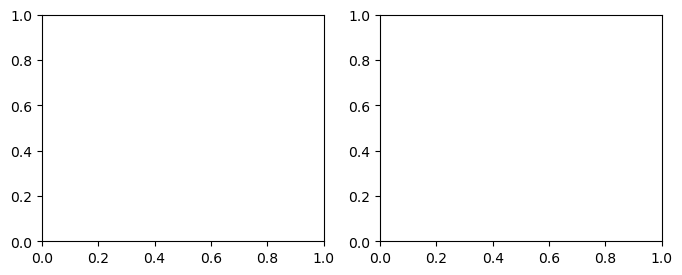

In [30]:
import seaborn
import matplotlib.pyplot as plt

palette = seaborn.color_palette('colorblind')

for kind in ['scatter', 'plot']:
    # first plot, periplasmic concentration
    fig, ax = plt.subplots(1, 2, figsize = (4*2, 3*1), dpi = 100)
    simulation.plot.metabolite(data3['avrg'], 'Alpha_lactose', 'per', ax = ax[0], **{'kind' : kind}, 
        plt_kws = {'s' : 2, 'color' : palette[0], 'label' : r'$\alpha$-lactose [PER]', 'alpha' : .5})

    # second plot, cytoplasmic concentration
    simulation.plot.metabolite(data3['avrg'], 'Alpha_lactose', 'cyt', ax = ax[1], **{'kind' : kind}, 
        plt_kws = {'s' : 2, 'color' : palette[1], 'label' : r'$\alpha$-lactose [CYT]', 'alpha' : .5})

    # second plot, cytoplasmic concentration
    simulation.plot.metabolite(data3['avrg'], 'ALLOLACTOSE', 'cyt', ax = ax[1], **{'kind' : kind}, 
        plt_kws = {'s' : 2, 'color' : palette[2], 'label' : r'allolactose [CYT]', 'alpha' : .5})
    
    ax[0].set_xlim((0,.25))
    ax[1].set_xlim((0,2.5))
    ax[0].set_ylim((0,100))
    ax[1].set_ylim((0,100))

    seaborn.despine()

NameError: name 'data3' is not defined

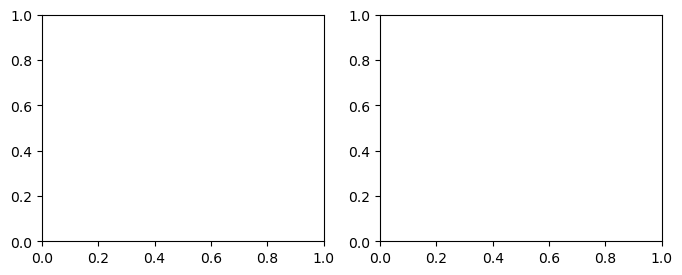

In [31]:
import seaborn
import matplotlib.pyplot as plt

palette = seaborn.color_palette('colorblind')

# first plot, periplasmic concentration
fig, ax = plt.subplots(1, 2, figsize = (4*2, 3*1), dpi = 100)
simulation.plot.metabolite(data3, 'Alpha_lactose', 'per', ax = ax[0], **{'kind' : 'fill_between', 'weight' : .5}, 
   plt_kws = {'s' : 2, 'color' : palette[0], 'label' : r'$\alpha$-lactose [PER]', 'alpha' : .5})

# second plot, cytoplasmic concentration
simulation.plot.metabolite(data3, 'Alpha_lactose', 'cyt', ax = ax[1], **{'kind' : 'fill_between', 'weight' : .5}, 
   plt_kws = {'s' : 2, 'color' : palette[1], 'label' : r'$\alpha$-lactose [CYT]', 'alpha' : .5})

# second plot, cytoplasmic concentration
simulation.plot.metabolite(data3, 'ALLOLACTOSE', 'cyt', ax = ax[1], **{'kind' : 'fill_between', 'weight' : .5}, 
   plt_kws = {'s' : 2, 'color' : palette[2], 'label' : r'allolactose [CYT]', 'alpha' : .5})

# first plot, periplasmic concentration
simulation.plot.metabolite(data0, 'Alpha_lactose', 'per', ax = ax[0], **{'kind' : kind}, 
   plt_kws = {'s' : 2, 'color' : palette[0], 'label' : r'ODE'})

# second plot, cytoplasmic concentration
simulation.plot.metabolite(data0, 'Alpha_lactose', 'cyt', ax = ax[1], **{'kind' : kind}, 
   plt_kws = {'s' : 2, 'color' : palette[1], 'label' : r'ODE'})

# second plot, cytoplasmic concentration
simulation.plot.metabolite(data0, 'ALLOLACTOSE', 'cyt', ax = ax[1], **{'kind' : kind}, 
   plt_kws = {'s' : 2, 'color' : palette[2], 'label' : r'ODE'})

ax[0].set_xlim((0,.25))
ax[1].set_xlim((0,2.5))
ax[0].set_ylim((0,100))
ax[1].set_ylim((0,100))

seaborn.despine()

As expected, the degradation of lactose into glucose and galactose is impossible due to a [disconnected pathway from $\alpha$-lactose to galatose](#figS2). The disconnected pathway will be
manually corrected and explained in a second tutorial. Also, we must note that we considered the enzymatic reactions are performed by the monomers (e.g. one monomer of LacZ catalyze one reaction), although biochemical information informs the monomers are catalytically active only when the complex is assembled (e.g. one LacZ tetramer catalyzes four reactions). This will be considered next, when we will model protein-protein interactions.

<!---
%Although system parameters could be found in databases or calibrated (e.g. with \textit{Pleione}, \citealp{Santibanez2019Pleione:}), the results show that modeling of RBMs for metabolic networks can be done in an automatized manner %and is a valid methodology to obtain genome-scale kinetic models of metabolism for deterministic and stochastic simulation.
--->

## Modeling protein-protein interactions

We could consult the stoichiometry of complexes with PythonCyc, and vice versa, quering which complexes are formed by a certain gene product (although indirectly):

In [32]:
import pythoncyc
print(pythoncyc.select_organism('ECOLI').monomers_of_protein('BETAGALACTOSID-CPLX'))
# we obtained the code "BETAGALACTOSID-CPLX" with the gathering of the metabolic data in "product" format.
print(pythoncyc.select_organism('ECOLI').monomers_of_protein('GALACTOACETYLTRAN-CPLX'))
# Similarly, the code "GALACTOACETYLTRAN-CPLX".

print(pythoncyc.select_organism('ECOLI').genes_of_protein('BETAGALACTOSID-CPLX'))
print(pythoncyc.select_organism('ECOLI').genes_of_protein('GALACTOACETYLTRAN-CPLX'))

print(pythoncyc.select_organism('ECOLI').all_products_of_gene('EG10527'))
print(pythoncyc.select_organism('ECOLI').all_products_of_gene('EG10524'))

[['|BETAGALACTOSID-MONOMER|'], [4]]
[['|GALACTOACETYLTRAN-MONOMER|'], [3]]
['|EG10527|']
['|EG10524|']
['|BETAGALACTOSID-MONOMER|', '|BETAGALACTOSID-CPLX|']
['|GALACTOACETYLTRAN-MONOMER|', '|GALACTOACETYLTRAN-CPLX|']


We included the function ```utils.interactionNetwork.FromGeneList()``` to write possible mechanism of assembly from the stoichiometry data of complexes.

In [33]:
%time network = utils.interactionNetwork.FromGeneList('ECOLI', genes = ['lacZ', 'lacA', 'lacY'], precalculated = df_genes)
network

CPU times: user 9.08 ms, sys: 4.72 ms, total: 13.8 ms
Wall time: 57 ms


,SOURCE,TARGET,LOCATION,FWD_RATE,RVS_RATE
0,lacA,lacA,"[cytosol,cytosol]",1.0,1.0
1,lacA,"[lacA,lacA]","[cytosol,cytosol,cytosol]",1.0,1.0
2,lacZ,lacZ,"[cytosol,cytosol]",1.0,1.0
3,lacZ,"[lacZ,lacZ]","[cytosol,cytosol,cytosol]",1.0,1.0
4,lacZ,"[lacZ,lacZ,lacZ]","[cytosol,cytosol,cytosol,cytosol]",1.0,1.0


In [34]:
atlas.read_network('network-lac-ProtProt.tsv')

,SOURCE,TARGET,FWD_RATE,RVS_RATE,LOCATION
0,lacZ,lacZ,1.0,0.0,cytosol
1,"[lacZ,lacZ]","[lacZ,lacZ]",1.0,0.0,cytosol
2,lacA,lacA,1.0,0.0,cytosol
3,lacA,"[lacA,lacA]",1.0,0.0,cytosol


Despite the effort, the function could retrieve interactions that would be hard to observe in nature (parsimony). Also, because we obtain from BioCyc the protein composition of complexes and not intermediates, we could miss interactions or add interactions that never occur because we programmed the complete enumeration of possible ordered mechanisms. From the network, we could remove interaction by its indexes, and add interactions defining its participants:

In [35]:
network = utils.interactionNetwork.removeInteraction(network, index = [3,4])
network = utils.interactionNetwork.addInteraction(network, source = ['lacZ', 'lacZ'], target = ['lacZ', 'lacZ'])
# we supposed a dimer-dimer interaction is more plausible than a trimer-monomer interaction to form a tetramer
network

,SOURCE,TARGET,LOCATION,FWD_RATE,RVS_RATE
0,lacA,lacA,"[cytosol,cytosol]",1.0,1.0
1,lacA,"[lacA,lacA]","[cytosol,cytosol,cytosol]",1.0,1.0
2,lacZ,lacZ,"[cytosol,cytosol]",1.0,1.0
3,"[lacZ,lacZ]","[lacZ,lacZ]",cytosol,1.0,1.0


**Note**: If the location of complexes do not match the number of components, Atlas will suppose the location (or the first defined location) is valid for all components of the final complex.

In [36]:
%time model = atlas.construct_model_from_interaction_network(network, verbose = False)
model

CPU times: user 144 ms, sys: 0 ns, total: 144 ms
Wall time: 144 ms


<Model 'atlas_rbm.construct_model_from_interaction_network' (monomers: 1, rules: 4, parameters: 14, expressions: 0, compartments: 0) at 0x7fe163e6d160>

In [37]:
utils.analyzeConnectivity(model)

Every rule may be applied.
Every monomer and complex of monomers may occur in the model.


In [38]:
# initial condition
# for proteins
simulation.set_initial.prot(model, 'lacZ', 'cyt', 12)
simulation.set_initial.prot(model, 'lacA', 'cyt', 12)

# simulation
bng = '/opt/git-repositories/bionetgen.RuleWorld/bng2/'
kasim = '/opt/git-repositories/KaSim4.Kappa-Dev/'
cupsoda = '/opt/git-repositories/cupSODA.aresio/'
stochkit = '/opt/git-repositories/StochKit.StochSS' # not the bin folder

%time data0 = simulation.scipy(model, start = 0, finish = 10, points = 2000)
%time data1 = simulation.cupsoda(model, start = 0, finish = 10, points = 2000, path = cupsoda)
%time data2 = simulation.bngODE(model, start = 0, finish = 10, points = 2000, path = bng)
%time data3 = simulation.bngSSA(model, start = 0, finish = 10, points = 2000, n_runs = 20, path = bng)
# %time data4 = simulation.bngPLA(model, start = 0, finish = 10, points = 2000, n_runs = 20, path = bng)
%time data5 = simulation.bngNF(model, start = 0, finish = 10, points = 2000, n_runs = 20, path = bng)
%time data6 = simulation.kasim(model, start = 0, finish = 10, points = 2000, n_runs = 20, path = kasim)
# %time data7 = simulation.stochkit(model, start = 0, finish = 10, points = 2000, n_runs = 20, path = stochkit) # pySB error

CPU times: user 1.08 s, sys: 89.1 ms, total: 1.17 s
Wall time: 2.5 s
CPU times: user 223 ms, sys: 28.8 ms, total: 252 ms
Wall time: 1.11 s
CPU times: user 263 ms, sys: 17.8 ms, total: 281 ms
Wall time: 823 ms
CPU times: user 1.35 s, sys: 41.8 ms, total: 1.4 s
Wall time: 2.61 s
CPU times: user 933 ms, sys: 78.7 ms, total: 1.01 s
Wall time: 2.45 s
CPU times: user 943 ms, sys: 190 ms, total: 1.13 s
Wall time: 2.05 s


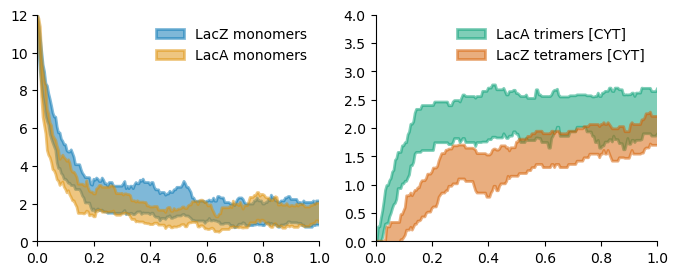

In [39]:
import seaborn
import matplotlib.pyplot as plt

palette = seaborn.color_palette('colorblind')

# first plot, periplasmic concentration
fig, ax = plt.subplots(1, 2, figsize = (4*2, 3*1), dpi = 100)
simulation.plot.protein(data3, 'lacZ', 'cyt', ax = ax[0], **{'kind' : 'fill_between', 'weight' : .5}, 
    plt_kws = {'s' : 2, 'color' : palette[0], 'label' : 'LacZ monomers', 'alpha' : .5})

simulation.plot.protein(data3, 'lacA', 'cyt', ax = ax[0], **{'kind' : 'fill_between', 'weight' : .5}, 
    plt_kws = {'s' : 2, 'color' : palette[1], 'label' : 'LacA monomers', 'alpha' : .5})

simulation.plot.cplx(data3, 'lacAx3', 'cyt', ax = ax[1], **{'kind' : 'fill_between', 'weight' : .5}, 
    plt_kws = {'s' : 2, 'color' : palette[2], 'label' : r'LacA trimers [CYT]', 'alpha' : .5})

simulation.plot.cplx(data3, 'lacZx4', 'cyt', ax = ax[1], **{'kind' : 'fill_between', 'weight' : .5}, 
   plt_kws = {'s' : 2, 'color' : palette[3], 'label' : r'LacZ tetramers [CYT]', 'alpha' : .5})

ax[0].set_xlim((0,1))
ax[1].set_xlim((0,1))
ax[0].set_ylim((0,12))
ax[1].set_ylim((0,4))

seaborn.despine()

## Modeling gene expression

To model gene expression (transcription and translation) we must first retrieve data for the genomic architecture of the considered genes. For this purpose, we could use the ```operon_of_gene``` method from the pythoncyc package to obtain the operons of a gene:

In [40]:
import pythoncyc
TUs = pythoncyc.select_organism('ECOLI').operon_of_gene(df_genes['gene name']['lacZ'])
TUs

['|TU0-4703|', '|TU00036|', '|TU0-4701|', '|TU0-4702|', '|TU0-14521|']

In [41]:
components = []
for TU in TUs:
    x = utils.getData('ECOLI', TU)['components']
    print(TU, '=', x)
    components.append(x)

|TU0-4703| = ['|TERM0223|', '|TERM0222|', '|EG10524|', '|EG10526|', '|EG10527|', '|PM0-4943|']
|TU00036| = ['|BS0-5469|', '|BS0-5468|', '|BS0-5467|', '|BS0-5463|', '|BS0-5462|', '|BS0-5461|', '|TERM0223|', '|TERM0222|', '|PM00045|', '|BS0-3622|', '|BS00104|', '|BS00105|', '|BS00106|', '|EG10524|', '|EG10526|', '|EG10527|']
|TU0-4701| = ['|TERM0223|', '|TERM0222|', '|BS0-3622|', '|EG10524|', '|EG10526|', '|EG10527|', '|PM0-4941|']
|TU0-4702| = ['|TERM0223|', '|TERM0222|', '|BS0-3622|', '|EG10524|', '|EG10526|', '|EG10527|', '|PM0-4942|']
|TU0-14521| = ['|TERM0223|', '|TERM0222|', '|EG10524|', '|EG10526|', '|PM0-9804|']


**Note**: An operon is a functional unit of DNA under the control of a promoter. In bacteria, operons could be policistronic (two or more genes under the control of a unique promoter) or monocistronic (only one gene under the control of a promoter). However, the information from the pythoncyc could led to misinterpretation of the genomic architecture, and we do not provide a function to cover all possibilities. Please, look at https://ecocyc.org/gene?orgid=ECOLI&id=EG10527#tab=TU and similar webpages to construct by yourself the network using a spreadsheet or text editor software.

Here is an example depicting the DNA architecture of the lactose operons (see above note an output of `operon_of_gene`). Using brackets, Atlas understand that DNA promoters, ribosome binding sites (RBS), coding DNA sequences (CDS), and terminators are part of the same architectural unit, and therefore, Atlas defines the RNA products and protein products. From the example, Atlas will write rules for the synthesis of 10 molecules of RNA (five promoters times two terminators), which produce three proteins:

In [42]:
utils.read_network('network-lac-operon-arq.tsv')

,UPSTREAM,DOWNSTREAM,RNAP_FWD_DOCK_RATE,RNAP_RVS_DOCK_RATE,RNAP_FWD_SLIDE_RATE,RNAP_FWD_FALL_RATE,RIB_FWD_DOCK_RATE,RIB_RVS_DOCK_RATE,RIB_FWD_SLIDE_RATE,RIB_FWD_FALL_RATE
0,[lacZ-pro4,lacZ-pro3,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,lacZ-pro3,lacZ-pro2,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,lacZ-pro2,lacZ-pro1,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,lacZ-pro1,lacZ-rbs,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,lacZ-rbs,lacZ-cds,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0
5,lacZ-cds,lacY-pro1,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,lacY-pro1,lacY-rbs,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
7,lacY-rbs,lacY-cds,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0
8,lacY-cds,lacA-rbs,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
9,lacA-rbs,lacA-cds,NaN,NaN,1.0,NaN,1.0,1.0,1.0,1.0


**Notes**:

- ```RNAP_FWD_DOCK_RATE```s and ```RNAP_RVS_DOCK_RATE```s are valid values only for the description of the reversible interaction of the RNA Polymerase to the promoters.
- ```RNAP_FWD_SLIDE_RATE```s are valid values for the transition of the RNA Polymerase from the ```UPSTREAM``` to the ```DOWNSTREAM``` DNA parts. We describe rules where the RNA Polymerase could not move back.
- ```RNAP_FWD_FALL_RATE```s are valid values only for the description of the unbinding of the RNA Polymerase and the ```UPSTREAM``` identifiying a DNA terminator.<br/><br/>

- ```RIB_FWD_DOCK_RATE```s and ```RIB_RVS_DOCK_RATE```s are valid values only for the description of the reversible interaction of the bacterial Ribosome to the RBS.
- ```RIB_FWD_SLIDE_RATE```s are valid values for the transition of the Ribosome from the ```UPSTREAM``` to the ```DOWNSTREAM``` RNA parts. We describe rules where the Ribosome could not move back.
- ```RIB_FWD_FALL_RATE```s are valid values only for the description of the unbinding of the Ribosome and the ```UPSTREAM``` identifiying a CDS.<br/><br/>

- Encode DNA parts as: "name of the gene"-"type of DNA part" (```pro#```: Promoter, ```rbs```: Ribosome Binding Site, ```cds```: Coding DNA Sequence, ```ter#```: (transcriptional) Terminator). Multiple promoters and terminators must have a numeric identifier (to replace `#`). For instance, `lacZ-pro1` identifies the most proximal promoter to the `lacZ` gene.
- In the case of Binding Sites (```BS```) for the interaction of Transcriptional Factors with DNA, please use the notation: BS-"name of the gene or regulator"-"upstream genomic coordinate"-"downstream genomic coordinate". The coordinates could be relatives or absolutes. For instance `BS-araC-56-72` describe the binding site located upstream the transcription start site of the araC gene, from the -56 nucleotide to the -72 nucleotide.

We provide two functions to reconstruction transcription and translation from the network of DNA parts (known as a "genome graph"). Here, we will use the first of these two functions. The ```construct_model_from_genome_graph()``` function is an automatization of the Kappa BioBrick Framework (https://www.sciencedirect.com/science/article/pii/S1571066111001289). The function writes rules for transcription of DNA mediated by a ```RNAP-CPLX``` agent (to keep notation with BioCyc) and translation of RNA mediated by a ```RIBOSOME-CPLX``` agent:

In [43]:
%time model = atlas.construct_model_from_genome_graph('network-lac-operon-arq.tsv')
model

CPU times: user 861 ms, sys: 13.6 ms, total: 875 ms
Wall time: 874 ms


<Model 'atlas_rbm.construct_model_from_genome_graph' (monomers: 4, rules: 28, parameters: 50, expressions: 0, compartments: 0) at 0x7fe15c636b20>

In [44]:
%time model = atlas.construct_model_from_genome_graph('network-ara-operons-arq.tsv')
model

CPU times: user 1.11 s, sys: 4.66 ms, total: 1.11 s
Wall time: 1.16 s


<Model 'atlas_rbm.construct_model_from_genome_graph' (monomers: 4, rules: 50, parameters: 78, expressions: 0, compartments: 0) at 0x7fe15c6546a0>

## Modeling regulation of gene expression

The second function that describe gene transcription and translation also consider the specificity of sigma factors for bacterial promoters. In bacteria, there is only one RNA polymerase that synthetize mRNA, rRNA, and tRNA. To control which genes are in active transcription, promoters show differential specificity for one or several sigma factors. In the case of *E. coli*, the bacteria has seven of those sigma factors: rpoD (exponential growth phase), rpoE (heat and protein misfolding stress), rpoH (heat stress), rpoN (nitrogen homeostasis), rpoS (stationary phase), fecI (iron starvation), and fliA (flagela synthesis) that interact with the core RNA polymerase (rpoAABC) and form an interaction interface for the holoenzyme with promoters.

In [45]:
utils.read_network('network-lac-sigma-specificity.tsv')

,SOURCE,TARGET,FWD_DOCK_RATE,RVS_DOCK_RATE,FWD_SLIDE_RATE
0,"[rpoA,rpoA,rpoB,rpoC,rpoD]",lacZ-pro4,1.0,1.0,1.0
1,"[rpoA,rpoA,rpoB,rpoC,rpoD]",lacZ-pro3,1.0,1.0,1.0
2,"[rpoA,rpoA,rpoB,rpoC,rpoD]",lacZ-pro2,1.0,1.0,1.0
3,"[rpoA,rpoA,rpoB,rpoC,rpoD]",lacZ-pro1,1.0,1.0,1.0
4,"[rpoA,rpoA,rpoB,rpoC,rpoD]",lacY-pro1,1.0,1.0,1.0


**Note**: The ```TARGET``` name must match the ```UPSTREAM``` name in the network that describe the genomic architecture:

In [46]:
network = utils.read_network('network-lac+rpoABCD-operons-arq.tsv')
network[['UPSTREAM', 'DOWNSTREAM']][network['UPSTREAM'].str.contains('pro')] # shows the UPSTREAM and DOWNSTREAM columns where the UPSTREAM column contains the 'pro' string

,UPSTREAM,DOWNSTREAM
0,[lacZ-pro4,lacZ-pro3
1,lacZ-pro3,lacZ-pro2
2,lacZ-pro2,lacZ-pro1
3,lacZ-pro1,lacZ-rbs
6,lacY-pro1,lacY-rbs
12,[rpoA-pro1,rpoA-rbs
15,[rpoB-pro1,rpoB-rbs
20,[rpoD-pro1,rpoD-rbs


In [47]:
%time model = atlas.construct_model_from_sigma_specificity_network('network-lac-sigma-specificity.tsv', 'network-lac+rpoABCD-operons-arq.tsv')
model

CPU times: user 1.33 s, sys: 5.14 ms, total: 1.33 s
Wall time: 1.33 s


<Model 'atlas_rbm.construct_model_from_sigma_specificity_network' (monomers: 4, rules: 55, parameters: 91, expressions: 0, compartments: 0) at 0x7fe163443f40>

In [48]:
%time model = atlas.construct_model_from_sigma_specificity_network('network-ara-sigma-specificity.tsv', 'network-ara+rpoABCD-operons-arq.tsv')

CPU times: user 1.7 s, sys: 0 ns, total: 1.7 s
Wall time: 1.72 s


However, sigma factors is only one of the many mechanism a bacteria has to control gene expression. Canonically speacking, Transcription Factors (TFs) drive the control of gene expression. TFs are proteins that bind to DNA or unbind from DNA at speciliazed sequences. Most TFs are sensors of metabolites: lacI senses allolactose, araC senses arabinose, crp senses cyclic AMP, etc. We employ an interaction network to model such information:

In [49]:
net1 = utils.read_network('network-lac+ara-TFs+DNA.tsv')
# net1 # for better visualization
net1[0:1]

,SOURCE,TARGET,FWD_RATE,RVS_RATE,LOCATION
0,"[crp,SMALL-CAMP,crp,SMALL-CAMP]",BS-crp-51-72,1.0,1.0,cytosol


**Note**: We appended the prefix ```SMALL-``` to tell Atlas that the interaction partner is a metabolite and not a protein (an interaction network is interpreted by default as a protein-protein interaction network). We employs the *hypergraph notation* to denote a complex of agents.

In [50]:
net2 = utils.read_network('network-lac+ara-ProtMet.tsv')
net3 = utils.read_network('network-lac-ProtProt.tsv')

Networks of the same kind (except metabolic networks) must be concatenated to produce valid models. Atlas numbers the rules and there is a probability to produce non unique rule names. In the case of metabolic networks, we use the reaction name to name rules (and check for unique names prior to write rules).

In [51]:
import pandas
network = pandas.concat([net1, net2, net3]).reset_index(drop = True)
# rules are numbered and networks of the same kind cannot be processed separately to then combine them into one bigger model (uniqueness of rule names)
# reset index is optional, but we used it to show the model produce all 30 interactions (index start at zero)
network[-5:]

,SOURCE,TARGET,FWD_RATE,RVS_RATE,LOCATION
30,"[araC,SMALL-alpha-L-arabinopyranose,araC]",SMALL-alpha-L-arabinopyranose,1.0,1.0,cytosol
31,lacZ,lacZ,1.0,0.0,cytosol
32,"[lacZ,lacZ]","[lacZ,lacZ]",1.0,0.0,cytosol
33,lacA,lacA,1.0,0.0,cytosol
34,lacA,"[lacA,lacA]",1.0,0.0,cytosol


In [52]:
%time model = atlas.construct_model_from_interaction_network(network)
model

CPU times: user 1.02 s, sys: 8.12 ms, total: 1.03 s
Wall time: 1.03 s


<Model 'atlas_rbm.construct_model_from_interaction_network' (monomers: 3, rules: 35, parameters: 89, expressions: 0, compartments: 0) at 0x7fe15d09ed90>

Data from the BioCyc database concerning regulation of gene expression could be obtained with help of the `utils.getData()` function. After obtaining the components of an operon, we could obtain the genomic coordinates of *most* of the DNA parts, and the center position of DNA binding sites:

In [53]:
for DNA_part in components[1]:
    data = utils.getData('ECOLI', DNA_part)
    print(DNA_part, data['left_end_position'], data['abs_center_pos'], data['right_end_position'])

|BS0-5469| None 366410 None
|BS0-5468| None 366397 None
|BS0-5467| None 366374 None
|BS0-5463| None 366348 None
|BS0-5462| None 366338 None
|BS0-5461| None 366320 None
|TERM0223| 361140 None 361179
|TERM0222| 361212 None 361236
|PM00045| None None None
|BS0-3622| None 366404.5 None
|BS00104| None 365932 None
|BS00105| None 366425 None
|BS00106| None 366333 None
|EG10524| 361249 None 361860
|EG10526| 361926 None 363179
|EG10527| 363231 None 366305


In [54]:
print(TUs[1])
for DNA_part in components[1]:
    data = utils.getData('ECOLI', DNA_part)
    if data['involved_in_regulation'] != None:
#         print(data['involved_in_regulation'][0])
        regulation = utils.getData('ECOLI', data['involved_in_regulation'][0])
        print(DNA_part, regulation['regulator'], regulation['mode'])
print()

print(TUs[2])
for DNA_part in components[2]:
    data = utils.getData('ECOLI', DNA_part)
    if data['involved_in_regulation'] != None:
#         print(data['involved_in_regulation'][0])
        regulation = utils.getData('ECOLI', data['involved_in_regulation'][0])
        print(DNA_part, regulation['regulator'], regulation['mode'])
print()

print(TUs[3])
for DNA_part in components[3]:
    data = utils.getData('ECOLI', DNA_part)
    if data['involved_in_regulation'] != None:
#         print(data['involved_in_regulation'][0])
        regulation = utils.getData('ECOLI', data['involved_in_regulation'][0])
        print(DNA_part, regulation['regulator'], regulation['mode'])

|TU00036|
|BS0-5469| |PD00288| ['-']
|BS0-5468| |PD00288| ['-']
|BS0-5467| |PD00288| ['-']
|BS0-5463| |PD00288| ['-']
|BS0-5462| |PD00288| ['-']
|BS0-5461| |PD00288| ['-']
|BS0-3622| |CPLX0-226| ['-']
|BS00104| |PD00763| ['-']
|BS00105| |PD00763| ['-']
|BS00106| |PD00763| ['-']

|TU0-4701|
|BS0-3622| |CPLX0-226| ['-']

|TU0-4702|
|BS0-3622| |CPLX0-226| ['-']


We hope you could format data by hand, as many interactions with a Transcription factor and a small metabolite are described as metabolic reactions, meanwhile we formatted that data as interaction networks:

In [55]:
print(utils.getData('ECOLI', 'CPLX0-226')['components']) # CPLX0-226 is the CRP-cAMP complex
print(utils.getData('ECOLI', 'CPLX0-226')['consensus_sequence']) # we could obtain the consensus DNA sequence if known
print(utils.getData('ECOLI', 'PC00004')['appears_in_left_side_of']) # in contrast to the "catalyzes" slot of gene products
print(utils.getData('ECOLI', 'BETAGALACTOSID-CPLX')['catalyzes'])
print(utils.getData('ECOLI', 'CPLX0-226')['appears_in_right_side_of']) # equivalent output
print(' + '.join(utils.getData('ECOLI', 'RXN0-269')['left']) + '->' + ' + '.join(utils.getData('ECOLI', 'RXN0-269')['right']))

['|PC00004|', '|CAMP|']
['AAATGTGAtctagaTCACATTT']
['|RXN0-269|']
['|BETAGALACTOSID-ENZRXN|', '|ENZRXN0-6526|', '|ENZRXN0-8150|', '|ENZRXN0-8152|']
['|RXN0-269|']
|PC00004| + |CAMP|->|CPLX0-226|


Finally, we will incorporate regulatory relationships through the copy of rules discribing the docking or sliding of the Ribosome through the DNA. For the inactivation of transcription by competition of a TF and a RNA polymerase for the same or overlapping binding site, we simple add interactions of the TF and copy the docking rule of the RNA polymerase with a condition:

In [56]:
%time network = utils.read_network('network-lac+ara-TFs+DNA.tsv')
network[0:5]

CPU times: user 2.71 ms, sys: 1.26 ms, total: 3.97 ms
Wall time: 3.29 ms


,SOURCE,TARGET,FWD_RATE,RVS_RATE,LOCATION
0,"[crp,SMALL-CAMP,crp,SMALL-CAMP]",BS-crp-51-72,1.0,1.0,cytosol
1,"[crp,SMALL-CAMP,crp,SMALL-CAMP]",BS-crp-22-1,1.0,1.0,cytosol
2,lacI,BS-lacI-422-402,1.0,1.0,cytosol
3,lacI,BS-lacI-21-1,1.0,1.0,cytosol
4,lacI,BS-lacI-72-92,1.0,1.0,cytosol


In [57]:
%time model1 = atlas.construct_model_from_interaction_network('network-lac+ara-TFs+DNA.tsv')
model1

CPU times: user 545 ms, sys: 335 µs, total: 545 ms
Wall time: 543 ms


<Model 'atlas_rbm.construct_model_from_interaction_network' (monomers: 3, rules: 24, parameters: 53, expressions: 0, compartments: 0) at 0x7fe15cfddbb0>

In [58]:
%time model2 = atlas.construct_model_from_sigma_specificity_network('network-lac-sigma-specificity.tsv', 'network-lac+rpoABCD-operons-arq.tsv')
model2

CPU times: user 1.44 s, sys: 9.17 ms, total: 1.45 s
Wall time: 1.45 s


<Model 'atlas_rbm.construct_model_from_sigma_specificity_network' (monomers: 4, rules: 55, parameters: 91, expressions: 0, compartments: 0) at 0x7fe15cfdd8e0>

In [59]:
%time model = atlas.combine_models([model1, model2], verbose = False)
model

CPU times: user 1.76 s, sys: 8.25 ms, total: 1.77 s
Wall time: 1.77 s


<Model 'atlas_rbm.atlas' (monomers: 5, rules: 79, parameters: 144, expressions: 0, compartments: 0) at 0x7fe15c69d0a0>

In [60]:
atlas.add_regulation(model, name = 'docking_2_lacZ_pro3', 
               conditions = ['BS-crp-51-72', 'BS-crp-22-1'], replace = True)

<Model 'atlas_rbm.atlas' (monomers: 5, rules: 79, parameters: 146, expressions: 0, compartments: 0) at 0x7fe15c69d0a0>

In [61]:
atlas.add_regulation(model, name = 'docking_3_lacZ_pro2', 
               conditions = ['BS-crp-51-72', 'BS-crp-22-1'], replace = True)

<Model 'atlas_rbm.atlas' (monomers: 5, rules: 79, parameters: 148, expressions: 0, compartments: 0) at 0x7fe15c69d0a0>

In [62]:
atlas.add_regulation(model, name = 'docking_4_lacZ_pro1', 
               conditions = ['[crp,SMALL-CAMP,crp,SMALL-CAMP,BS-crp-51-72]', 
                             '[crp,SMALL-CAMP,crp,SMALL-CAMP,BS-crp-22-1]'], replace = True)

<Model 'atlas_rbm.atlas' (monomers: 5, rules: 79, parameters: 150, expressions: 0, compartments: 0) at 0x7fe15c69d0a0>